# IND320 - Data to Decision
**Student:** Sofie Lauvås

**Project:** Combining Climate and Energy Data for Time Series Forecasting

**GitHub Repository:** https://github.com/sofielauvaas/IND320_sofielauvaas_project

**Streamlit App:** https://ind320sofielauvaasproject.streamlit.app/


### 1. Project Setup and Library Imports

In [1]:
import pandas as pd
import numpy as np
import requests
import datetime as dt
import json
from pymongo.mongo_client import MongoClient
import tomllib
from scipy.fft import dct, idct
from scipy.signal import spectrogram
from statsmodels.tsa.seasonal import STL 
from sklearn.neighbors import LocalOutlierFactor 
import matplotlib.pyplot as plt 
import plotly.graph_objects as go
from plotly.subplots import make_subplots

### 2. Data Sourcing: API Retrieval and Quality Checks

#### 2.1 Geographic Definition and API Download Function

In [2]:
# Coordinates for the five Norwegian electricity price area representatives.
geo_data = {
    'Price_Area': ['NO1', 'NO2', 'NO3', 'NO4', 'NO5'],
    'City': ['Oslo', 'Kristiansand', 'Trondheim', 'Tromsø', 'Bergen'],
    'Latitude': [59.9122, 58.1599, 63.4305, 69.6498, 60.3913],
    'Longitude': [10.7313, 8.0182, 10.3951, 18.9841, 5.3221]
}
df_geo = pd.DataFrame(geo_data)
print("Geographical Data:")
print(df_geo)

Geographical Data:
  Price_Area          City  Latitude  Longitude
0        NO1          Oslo   59.9122    10.7313
1        NO2  Kristiansand   58.1599     8.0182
2        NO3     Trondheim   63.4305    10.3951
3        NO4        Tromsø   69.6498    18.9841
4        NO5        Bergen   60.3913     5.3221


#### 2.2 Required Download Test: Bergen, 2019

In [3]:
def download_weather_data(latitude, longitude, year):
    """
    Downloads hourly historical ERA5 Reanalysis weather data from Open-Meteo.
    """
    start_date = f"{year}-01-01"
    end_date = f"{year}-12-31"

    BASE_URL = "https://archive-api.open-meteo.com/v1/archive?"
    
    # Required weather properties
    hourly_variables = [
        "temperature_2m", 
        "precipitation", 
        "wind_speed_10m", 
        "wind_gusts_10m",
        "wind_direction_10m"
    ]
    
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date,
        "end_date": end_date,
        "hourly": hourly_variables,
        "timezone": "auto",
    }
    
    response = requests.get(BASE_URL, params=params)
    response.raise_for_status() # Check for HTTP errors
    data = response.json()
    
    # Convert the hourly data into a Pandas DataFrame
    hourly_data = data['hourly']
    df = pd.DataFrame(hourly_data)
    df['time'] = pd.to_datetime(df['time'])
    df = df.set_index('time')
    
    print(f"\nDownloaded data for Lat: {latitude}, Lon: {longitude} for {year}.")
    return df

# Test the API Function (Bergen, 2019)
bergen_coords = df_geo[df_geo['City'] == 'Bergen'].iloc[0]
bergen_lat = bergen_coords['Latitude']
bergen_lon = bergen_coords['Longitude']

df_bergen_2019 = download_weather_data(bergen_lat, bergen_lon, 2019)
print("\nBergen 2019 Data Head:")
print(df_bergen_2019.head())
print(f"Shape: {df_bergen_2019.shape}")


Downloaded data for Lat: 60.3913, Lon: 5.3221 for 2019.

Bergen 2019 Data Head:
                     temperature_2m  precipitation  wind_speed_10m  \
time                                                                 
2019-01-01 00:00:00             5.7            0.7            37.0   
2019-01-01 01:00:00             5.8            0.2            41.0   
2019-01-01 02:00:00             6.1            0.7            42.0   
2019-01-01 03:00:00             6.3            0.5            40.9   
2019-01-01 04:00:00             5.8            1.1            41.2   

                     wind_gusts_10m  wind_direction_10m  
time                                                     
2019-01-01 00:00:00            99.7                 263  
2019-01-01 01:00:00           107.3                 278  
2019-01-01 02:00:00           112.0                 286  
2019-01-01 03:00:00           105.8                 298  
2019-01-01 04:00:00           110.2                 315  
Shape: (8760, 5)


### 3. Analysis Functions: Outliers and Anomalies


#### 3.1 Anomaly Detection: SPC and LOF

In [4]:
# Helper Function for DCT Filtering 
def dct_highpass_filter(signal, keep_fraction):
    """ High-pass filter using DCT to separate trend from SATV. """
    x = np.asarray(signal, dtype=float)
    X = dct(x, norm="ortho")
    n = len(X)
    k_low = max(1, int(n * keep_fraction)) 
    
    # Trend (Low-Pass Component)
    X_lp = np.zeros_like(X)
    X_lp[:k_low] = X[:k_low]
    trend = idct(X_lp, norm="ortho")
    
    # SATV (High-Pass Component)
    satv = x - trend
    return satv, trend

In [5]:
def temperature_spc_from_satv(
    time, temperature,
    keep_low_fraction=0.01, k=3.0, robust=True, scale_mad=True
):
    """
    Detects temperature outliers using robust SPC boundaries derived from SATV (DCT Adjusted).
    
    Returns the Plotly figure and a summary dictionary of outlier statistics.
    """
    t = np.asarray(time)
    x = np.asarray(temperature, dtype=float)
    n = len(x)
    
    # Separate SATV and Trend
    satv, trend = dct_highpass_filter(x, keep_low_fraction)
    
    # Robust statistics on SATV
    if robust:
        center = np.median(satv)
        mad = np.median(np.abs(satv - center))
        spread = (1.4826 * mad) if scale_mad else mad
    else:
        center = np.mean(satv)
        spread = np.std(satv)
    
    upper_satv = center + k * spread
    lower_satv = center - k * spread
    
    # Dynamic control curves
    upper_curve = trend + upper_satv
    lower_curve = trend + lower_satv
    
    # Outliers determined in SATV space
    is_outlier = (satv > upper_satv) | (satv < lower_satv)
    
    # Build Plotly figure (Plotting logic remains the same)
    fig = go.Figure()
    
    UCL_name = f"UCL"
    LCL_name = f"LCL"

    fig.add_trace(go.Scatter(
        x=t[~is_outlier], y=x[~is_outlier],
        mode="lines", name="Temperature (Inliers)",
        line=dict(color='#035397', width=1.0)
    ))
    fig.add_trace(go.Scatter(
        x=t[is_outlier], y=x[is_outlier],
        mode="markers", name="Outliers (SPC)",
        marker=dict(color='#128264', size=6, opacity=0.9)
    ))
    fig.add_trace(go.Scatter(
        x=t, y=upper_curve, mode="lines", name=UCL_name,
        line=dict(color='#f9c80e', dash="dash", width=1.5)
    ))
    fig.add_trace(go.Scatter(
        x=t, y=lower_curve, mode="lines", name=LCL_name,
        line=dict(color='#f9c80e', dash="dash", width=1.5)
    ))
    
    fig.update_layout(
        template="plotly_white",
        title=f"Temperature Outliers Detected via Robust SPC (Bergen 2019)",
        xaxis_title="Date", yaxis_title="Temperature (°C)", title_x=0.5
    )
    
    summary = {"n_outliers": int(is_outlier.sum()), "n_total": int(n), "percent_outliers": round(100 * is_outlier.mean(), 2)}
    return fig, summary

In [6]:
# Prepare data for plotting
bergen_2019 = df_bergen_2019.reset_index().rename(columns={'time': 'time'})

# 1. Test Temperature SPC
print("Temperature SPC Summary")
fig_spc, summary_spc = temperature_spc_from_satv(
    time=bergen_2019["time"].to_numpy(),
    temperature=bergen_2019["temperature_2m"].to_numpy(),
)
print(summary_spc)
fig_spc.show()

Temperature SPC Summary
{'n_outliers': 58, 'n_total': 8760, 'percent_outliers': np.float64(0.66)}


The SPC plot shows temperature with dynamic control limits based on the Seasonally Adjusted Temperature Variation (SATV). The detected outliers (red markers) represent short, extreme cold and heat spells that are unusual for their respective seasons.

In [7]:
# Apply the DCT high-pass filter 
satv_values, _ = dct_highpass_filter(
    bergen_2019["temperature_2m"].to_numpy(),
    keep_fraction=0.01
)
bergen_2019["SATV"] = satv_values


# Plot histogram of SATV values to confirm normal distribution
SATV_COLOR = '#035397' 

fig_hist = go.Figure(data=[go.Histogram(
    x=bergen_2019["SATV"],
    nbinsx=50,
    marker_color=SATV_COLOR
)])

fig_hist.update_layout(
    template="plotly_white",
    title="Distribution of SATV (Bergen 2019)",
    xaxis_title="SATV (°C)",
    yaxis_title="Count",
    title_x=0.5
)
fig_hist.show()

The histogram of SATV shows a symmetric, bell-shaped distribution centered near zero. This confirms that the DCT filtering successfully removed the slow seasonal trend, leaving short-term variations that are approximately normally distributed, which validates the use of robust SPC methods for anomaly detection on this feature.

In [8]:
# LOF Function 
def precipitation_lof_plot(time, precipitation, contamination=0.01, n_neighbors=30):
    """ 
    Detects and plots precipitation anomalies using the Local Outlier Factor (LOF). 

    Returns the Plotly figure and a summary dictionary of anomaly statistics.
    """
    X = np.array(precipitation.fillna(0)).reshape(-1, 1)

    # Fit Local Outlier Factor
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
    labels = lof.fit_predict(X) 
    is_outlier = labels == -1
    n_outliers = int(is_outlier.sum())
    n_total = len(X)

    # Plotting
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=np.array(time)[~is_outlier], y=X[~is_outlier, 0],
        mode="lines", name="Precipitation (Inliers)",
        line=dict(color='#035397', width=1.0)
    ))

    fig.add_trace(go.Scatter(
        x=np.array(time)[is_outlier], y=X[is_outlier, 0],
        mode="markers", name="Anomalies (LOF)",
        marker=dict(color="#128264", size=6, opacity=0.8)
    ))

    fig.update_layout(
        template="plotly_white",
        title=f"Precipitation Anomalies via LOF (Contamination: {contamination*100:.1f}%)",
        xaxis_title="Date", yaxis_title="Precipitation (mm/h)", title_x=0.5
    )

    summary = {"n_total": n_total, "n_outliers": n_outliers, "percent_outliers": round(100 * n_outliers / n_total, 2)}
    return fig, summary

# Test Precipitation LOF
print("\nPrecipitation LOF Summary:")
fig_lof, summary_lof = precipitation_lof_plot(
    time=bergen_2019["time"],
    precipitation=bergen_2019["precipitation"],
)
print(summary_lof)
fig_lof.show()


Precipitation LOF Summary:
{'n_total': 8760, 'n_outliers': 87, 'percent_outliers': 0.99}


/opt/miniconda3/envs/D2D_env/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:322: UserWarning:

Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.



The LOF plot identifies the least dense points as anomalies. Due to the high frequency of zero precipitation, LOF flags both the extreme high-magnitude rain spikes and some intermediate non-zero values (around 2 mm/h) which are locally sparse relative to the dense cluster at zero.

#### 3.2 Data Sourcing: Elhub Production Data (MongoDB)

In [9]:
# Read secrets from the TOML file
# NOTE: Assumes secrets.toml is accessible via this relative path
with open("../.streamlit/secrets.toml", "rb") as f:
    cfg = tomllib.load(f)

# Access connection details
uri = cfg["mongodb"]["uri"]
db_name = cfg["mongodb"]["database"]
col_name = cfg["mongodb"]["collection"]

# Connect and fetch data
client = MongoClient(uri)
db = client[db_name]
collection = db[col_name] 

# Retrieve all documents into a list (excluding the MongoDB '_id')
data = list(collection.find({}, {"_id": 0})) 
df = pd.DataFrame(data)

# Standardize column names and types
if 'starttime' in df.columns:
    df["starttime"] = pd.to_datetime(df["starttime"])
df.columns = [c.lower() for c in df.columns]

print(f"Elhub data loaded. Shape: {df.shape}")
print(df.head())

Elhub data loaded. Shape: (215353, 4)
  pricearea productiongroup           starttime  quantitykwh
0       NO3           other 2021-01-01 00:00:00          0.0
1       NO3           other 2021-01-01 01:00:00          0.0
2       NO3           other 2021-01-01 02:00:00          0.0
3       NO3           other 2021-01-01 03:00:00          0.0
4       NO3           other 2021-01-01 04:00:00          0.0


#### 3.3 Time Series Decomposition (STL) and Frequency Analysis (Spectrogram)

In [10]:
# STL Decomposition Function
def stl_decomposition_elhub(df, pricearea="NO5", productiongroup="hydro", period=168, seasonal=9, trend=241, robust=False):
    """ 
    Performs STL decomposition on Elhub production data and returns a Plotly figure 
    of the Observed, Trend, Seasonal, and Remainder components.
    """
    line_color = '#416287' 
    subset = df[(df["pricearea"].str.upper() == pricearea.upper()) & (df["productiongroup"].str.lower() == productiongroup.lower())].copy()
    
    subset = subset.set_index(pd.to_datetime(subset["starttime"]))
    ts = subset.groupby(level=0)['quantitykwh'].sum()
    ts = ts.asfreq('h')
    ts.sort_index(inplace=True)
    ts = ts.ffill() 
    
    # STL fitting
    result = STL(ts, period=period, seasonal=seasonal, trend=trend, robust=robust).fit()
    components_map = {"Observed": ts, "Trend": result.trend, "Seasonal": result.seasonal, "Remainder": result.resid}
    
    # Plotly subplot creation
    fig = make_subplots(rows=4, cols=1, shared_xaxes=True, subplot_titles=("Observed", "Trend", "Seasonal", "Remainder"), vertical_spacing=0.04)
    for i, (name, component_series) in enumerate(components_map.items()):
        fig.add_trace(go.Scatter(x=component_series.index, y=component_series.values, mode="lines", line=dict(color=line_color, width=1), name=name), row=i + 1, col=1)
    
    fig.update_layout(height=950, template="plotly_white", title=f"STL Decomposition — {pricearea.upper()} {productiongroup.capitalize()}", title_x=0.5, showlegend=False, margin=dict(t=80, b=50, l=50, r=20))
    fig.update_xaxes(title_text="Date", row=4, col=1)
    return fig

# Test STL Function
fig_stl = stl_decomposition_elhub(df=df, pricearea="NO1", productiongroup="hydro")
fig_stl.show()

The STL decomposition for NO1 Hydro production clearly separates the seasonal patterns from the long-term trend and the residual noise. The seasonal component shows strong recurring cycles, while the remainder now distinctly highlights two major anomalies in late October and early November, which are production events not captured by the normal trend or seasonality.

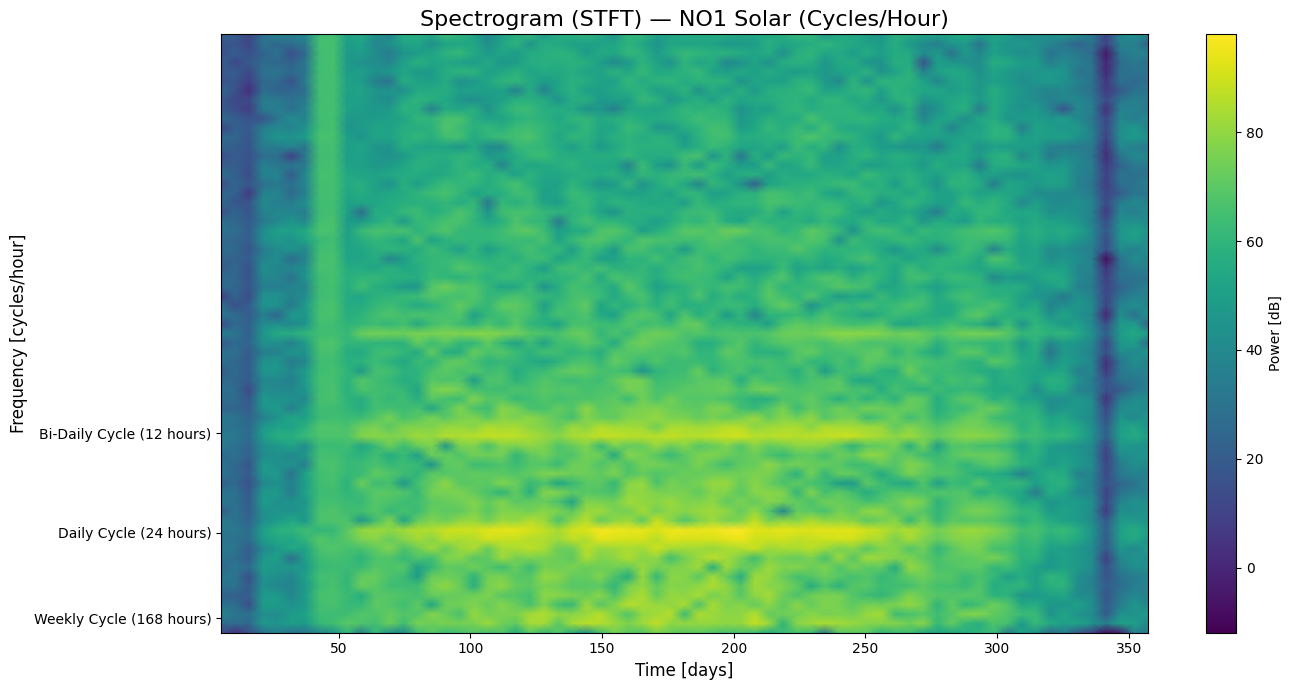

In [11]:
# Spectrogram
def create_spectrogram(
    df_prod, 
    price_area='NO5', 
    prod_group='hydro', 
    window_length=256, # 256 hours for good frequency resolution
    overlap=128          # 50% overlap for smooth transitions
):
    """ Creates an image-like spectrogram using Matplotlib's pcolormesh and shading='gouraud'. """
    
    subset = df_prod[
        (df_prod['pricearea'].str.upper() == price_area.upper()) & 
        (df_prod['productiongroup'].str.lower() == prod_group.lower())
    ].sort_values("starttime")

    ts = subset["quantitykwh"].values
    if ts.min() <= 0:
        ts = ts + 1e-9 
        
    fs = 1.0 # 1 sample per hour
    f, t_hours, Sxx = spectrogram(ts, fs=fs, nperseg=window_length, noverlap=overlap, detrend='constant')

    power_db = 10 * np.log10(Sxx)
    
    # Matplotlib plotting
    fig, ax = plt.subplots(figsize=(14, 7))
    im = ax.pcolormesh(
        t_hours / 24,           
        f, 
        power_db,               
        shading='gouraud', 
        cmap='viridis'
    )
    
    ax.set_title(f"Spectrogram (STFT) — {price_area.upper()} {prod_group.capitalize()} (Cycles/Hour)", fontsize=16)
    ax.set_xlabel("Time [days]", fontsize=12)
    ax.set_ylabel("Frequency [cycles/hour]", fontsize=12)
    
    # Set Y-axis to focus on the key cycles
    ax.set_ylim(0, 0.25)
    ax.set_yticks([1/24, 2/24, 1/168])
    ax.set_yticklabels([
        'Daily Cycle (24 hours)', 
        'Bi-Daily Cycle (12 hours)', 
        'Weekly Cycle (168 hours)'
    ])
    fig.colorbar(im, ax=ax, label="Power [dB]")
    plt.tight_layout()
    plt.show()
    return fig


# Test Spectrogram
plot_spectrogram = create_spectrogram(df, price_area='NO1', prod_group='solar')
plt.show()

The resulting Spectrogram for NO1 Solar production confirms the signal is driven by strong, predictable, and clean cycles. The plot's power is concentrated in the low-frequency area, with the brightest band being the Daily Cycle (24 hours), showing the sun's rhythm is the main source of power. The Bi-Daily Cycle (12 hours) is also strong. You can see several fainter bands above the 12-hour cycle (the harmonics), which represent other mathematical components needed to model the sharp shape of the solar signal. The areas outside these bands are mostly darker, confirming the signal is generally very smooth with only low, random background noise.

## AI Usage

## Log